In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging
import multiprocessing

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import scipy.stats as stats

import numpyro
import numpyro.distributions as dist

from hbmep.model import Baseline
from hbmep_paper.utils.constants import HBM
from hbmep.config import Config
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)


In [2]:
class Simulation(Baseline):
    LINK = HBM

    def __init__(self, config: Config, mu_a_delta: int, sigma_a_delta: int):
        super(Simulation, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]
        self.mu_a_delta = mu_a_delta
        self.sigma_a_delta = sigma_a_delta

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        n_baseline = 1
        n_delta = 1

        global_sigma_b_baseline = numpyro.sample("global_sigma_b_baseline", dist.HalfNormal(100))
        global_sigma_v_baseline = numpyro.sample("global_sigma_v_baseline", dist.HalfNormal(100))

        global_sigma_L_baseline = numpyro.sample("global_sigma_L_baseline", dist.HalfNormal(50))
        global_sigma_H_baseline = numpyro.sample("global_sigma_H_baseline", dist.HalfNormal(500))

        global_sigma_g_1_baseline = numpyro.sample("global_sigma_g_1_baseline", dist.HalfNormal(100))
        global_sigma_g_2_baseline = numpyro.sample("global_sigma_g_2_baseline", dist.HalfNormal(100))

        """ Baseline """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                """ Hyper-priors """
                mu_a_baseline = numpyro.sample(
                    "mu_a_baseline",
                    dist.TruncatedNormal(50, 50, low=0)
                )
                sigma_a_baseline = numpyro.sample(
                    "sigma_a_baseline",
                    dist.HalfNormal(50)
                )

                sigma_b_baseline = numpyro.sample("sigma_b_baseline", dist.HalfNormal(global_sigma_b_baseline))
                sigma_v_baseline = numpyro.sample("sigma_v_baseline", dist.HalfNormal(global_sigma_v_baseline))

                sigma_L_baseline = numpyro.sample("sigma_L_baseline", dist.HalfNormal(global_sigma_L_baseline))
                sigma_H_baseline = numpyro.sample("sigma_H_baseline", dist.HalfNormal(global_sigma_H_baseline))

                sigma_g_1_baseline = numpyro.sample("sigma_g_1_baseline", dist.HalfNormal(global_sigma_g_1_baseline))
                sigma_g_2_baseline = numpyro.sample("sigma_g_2_baseline", dist.HalfNormal(global_sigma_g_2_baseline))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a_baseline = numpyro.sample(
                        "a_baseline",
                        dist.TruncatedNormal(mu_a_baseline, sigma_a_baseline, low=0)
                    )

                    b_baseline = numpyro.sample("b_baseline", dist.HalfNormal(sigma_b_baseline))
                    v_baseline = numpyro.sample("v_baseline", dist.HalfNormal(sigma_v_baseline))

                    L_baseline = numpyro.sample("L_baseline", dist.HalfNormal(sigma_L_baseline))
                    H_baseline = numpyro.sample("H_baseline", dist.HalfNormal(sigma_H_baseline))

                    g_1_baseline = numpyro.sample("g_1_baseline", dist.Exponential(sigma_g_1_baseline))
                    g_2_baseline = numpyro.sample("g_2_baseline", dist.Exponential(sigma_g_2_baseline))

        """ Delta """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_delta", n_delta, dim=-2):
                mu_a_delta = numpyro.deterministic("mu_a_delta", self.mu_a_delta)
                sigma_a_delta = numpyro.deterministic("sigma_a_delta", self.sigma_a_delta)

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    a_delta = numpyro.sample("a_delta", dist.Normal(mu_a_delta, sigma_a_delta))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([a_baseline, a_baseline + a_delta], axis=1)
                    )

                    b = numpyro.deterministic(
                        site.b,
                        jnp.concatenate([b_baseline, b_baseline], axis=1)
                    )
                    v = numpyro.deterministic(
                        site.v,
                        jnp.concatenate([v_baseline, v_baseline], axis=1)
                    )

                    L = numpyro.deterministic(
                        site.L,
                        jnp.concatenate([L_baseline, L_baseline], axis=1)
                    )
                    H = numpyro.deterministic(
                        site.H,
                        jnp.concatenate([H_baseline, H_baseline], axis=1)
                    )

                    g_1 = numpyro.deterministic(
                        site.g_1,
                        jnp.concatenate([g_1_baseline, g_1_baseline], axis=1)
                    )
                    g_2 = numpyro.deterministic(
                        site.g_2,
                        jnp.concatenate([g_2_baseline, g_2_baseline], axis=1)
                    )

                    # a = numpyro.deterministic(site.a, a_baseline)

                    # b = numpyro.deterministic(site.b, b_baseline)
                    # v = numpyro.deterministic(site.v, v_baseline)

                    # L = numpyro.deterministic(site.L, L_baseline)
                    # H = numpyro.deterministic(site.H, H_baseline)

                    # g_1 = numpyro.deterministic(site.g_1, g_1_baseline)
                    # g_2 = numpyro.deterministic(site.g_2, g_2_baseline)

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[subject, feature0]
            + jnp.maximum(
                0,
                -1
                + (H[subject, feature0] + 1)
                / jnp.power(
                    1
                    + (jnp.power(1 + H[subject, feature0], v[subject, feature0]) - 1)
                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0])),
                    1 / v[subject, feature0]
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[subject, feature0] + g_2[subject, feature0] * (1 / mu) ** 2
        )

        # """ Penalty """
        # penalty = (jnp.fabs(baseline + delta) - (baseline + delta))
        # numpyro.factor("penalty", -penalty)

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )



In [3]:
class HierarchicalBayesianModel(Baseline):
    LINK = HBM

    def __init__(self, config: Config):
        super(HierarchicalBayesianModel, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        n_baseline = 1
        n_delta = 1

        global_sigma_b_baseline = numpyro.sample("global_sigma_b_baseline", dist.HalfNormal(100))
        global_sigma_v_baseline = numpyro.sample("global_sigma_v_baseline", dist.HalfNormal(100))

        global_sigma_L_baseline = numpyro.sample("global_sigma_L_baseline", dist.HalfNormal(50))
        global_sigma_H_baseline = numpyro.sample("global_sigma_H_baseline", dist.HalfNormal(500))

        global_sigma_g_1_baseline = numpyro.sample("global_sigma_g_1_baseline", dist.HalfNormal(100))
        global_sigma_g_2_baseline = numpyro.sample("global_sigma_g_2_baseline", dist.HalfNormal(100))

        """ Baseline """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                """ Hyper-priors """
                mu_a_baseline = numpyro.sample(
                    "mu_a_baseline",
                    dist.TruncatedNormal(50, 50, low=0)
                )
                sigma_a_baseline = numpyro.sample(
                    "sigma_a_baseline",
                    dist.HalfNormal(50)
                )

                sigma_b_baseline = numpyro.sample("sigma_b_baseline", dist.HalfNormal(global_sigma_b_baseline))
                sigma_v_baseline = numpyro.sample("sigma_v_baseline", dist.HalfNormal(global_sigma_v_baseline))

                sigma_L_baseline = numpyro.sample("sigma_L_baseline", dist.HalfNormal(global_sigma_L_baseline))
                sigma_H_baseline = numpyro.sample("sigma_H_baseline", dist.HalfNormal(global_sigma_H_baseline))

                sigma_g_1_baseline = numpyro.sample("sigma_g_1_baseline", dist.HalfNormal(global_sigma_g_1_baseline))
                sigma_g_2_baseline = numpyro.sample("sigma_g_2_baseline", dist.HalfNormal(global_sigma_g_2_baseline))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a_baseline = numpyro.sample(
                        "a_baseline",
                        dist.TruncatedNormal(mu_a_baseline, sigma_a_baseline, low=0)
                    )

                    b_baseline = numpyro.sample("b_baseline", dist.HalfNormal(sigma_b_baseline))
                    v_baseline = numpyro.sample("v_baseline", dist.HalfNormal(sigma_v_baseline))

                    L_baseline = numpyro.sample("L_baseline", dist.HalfNormal(sigma_L_baseline))
                    H_baseline = numpyro.sample("H_baseline", dist.HalfNormal(sigma_H_baseline))

                    g_1_baseline = numpyro.sample("g_1_baseline", dist.Exponential(sigma_g_1_baseline))
                    g_2_baseline = numpyro.sample("g_2_baseline", dist.Exponential(sigma_g_2_baseline))

        """ Delta """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_delta", n_delta, dim=-2):
                mu_a_delta = numpyro.sample("mu_a_delta", dist.Normal(0, 100))
                sigma_a_delta = numpyro.sample("sigma_a_delta", dist.HalfNormal(100))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    a_delta = numpyro.sample("a_delta", dist.Normal(mu_a_delta, sigma_a_delta))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([a_baseline, a_baseline + a_delta], axis=1)
                    )

                    b = numpyro.deterministic(
                        site.b,
                        jnp.concatenate([b_baseline, b_baseline], axis=1)
                    )
                    v = numpyro.deterministic(
                        site.v,
                        jnp.concatenate([v_baseline, v_baseline], axis=1)
                    )

                    L = numpyro.deterministic(
                        site.L,
                        jnp.concatenate([L_baseline, L_baseline], axis=1)
                    )
                    H = numpyro.deterministic(
                        site.H,
                        jnp.concatenate([H_baseline, H_baseline], axis=1)
                    )

                    g_1 = numpyro.deterministic(
                        site.g_1,
                        jnp.concatenate([g_1_baseline, g_1_baseline], axis=1)
                    )
                    g_2 = numpyro.deterministic(
                        site.g_2,
                        jnp.concatenate([g_2_baseline, g_2_baseline], axis=1)
                    )

                    # a = numpyro.deterministic(site.a, a_baseline)

                    # b = numpyro.deterministic(site.b, b_baseline)
                    # v = numpyro.deterministic(site.v, v_baseline)

                    # L = numpyro.deterministic(site.L, L_baseline)
                    # H = numpyro.deterministic(site.H, H_baseline)

                    # g_1 = numpyro.deterministic(site.g_1, g_1_baseline)
                    # g_2 = numpyro.deterministic(site.g_2, g_2_baseline)

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[subject, feature0]
            + jnp.maximum(
                0,
                -1
                + (H[subject, feature0] + 1)
                / jnp.power(
                    1
                    + (jnp.power(1 + H[subject, feature0], v[subject, feature0]) - 1)
                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0])),
                    1 / v[subject, feature0]
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[subject, feature0] + g_2[subject, feature0] * (1 / mu) ** 2
        )

        # """ Penalty """
        # penalty = (jnp.fabs(baseline + delta) - (baseline + delta))
        # numpyro.factor("penalty", -penalty)

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )


In [4]:
mu_a_delta = -1.5
sigma_a_delta = 1

toml_path = "/home/vishu/repos/hbmep-paper/configs/human/tms/mixed-effects.toml"
CONFIG = Config(toml_path=toml_path)

MODEL = Simulation(config=CONFIG, mu_a_delta=mu_a_delta, sigma_a_delta=sigma_a_delta)

src = "/home/vishu/data/hbmep-processed/human/tms/data.csv"
DF = pd.read_csv(src)

DF[MODEL.features[0]] = 0
DF[MODEL.response] = DF[MODEL.response] * 1000

DF, ENCODER_DICT = MODEL.load(df=DF)

dest = os.path.join(MODEL.build_dir, "inference.pkl")
with open(dest, "rb") as g:
    _, MCMC, POSTERIOR_SAMPLES = pickle.load(g)

2023-10-12 11:08:44,638 - hbmep.config - INFO - Verifying configuration ...
2023-10-12 11:08:44,638 - hbmep.config - INFO - Success!
2023-10-12 11:08:44,670 - hbmep.model.baseline - INFO - Initialized model with hierarchical_bayesian link
2023-10-12 11:08:44,681 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects
2023-10-12 11:08:44,681 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects
2023-10-12 11:08:44,682 - hbmep.dataset.core - INFO - Processing data ...
2023-10-12 11:08:44,684 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [5]:
prefix = "power-analysis-parallel"
prefix_2 = f"mu_a_delta_{mu_a_delta}_sigma_a_delta_{sigma_a_delta}"

priors = {
    site.a, "a_baseline",
    site.b, "b_baseline",
    site.v, "v_baseline",
    site.L, "L_baseline",
    site.H, "H_baseline",
    site.g_1, "g_1_baseline",
    site.g_2, "g_2_baseline",
    site.mu, site.beta
}

POST = {u: v for u, v in POSTERIOR_SAMPLES.items() if u not in priors}

""" Experiment """
TOTAL_SUBJECTS = 200

PREDICTION_DF = \
    pd.DataFrame(np.arange(0, TOTAL_SUBJECTS, 1), columns=[MODEL.subject]) \
    .merge(
        pd.DataFrame(np.arange(0, 2, 1), columns=MODEL.features),
        how="cross"
    ) \
    .merge(
        pd.DataFrame([0, 100], columns=[MODEL.intensity]),
        how="cross"
    )
PREDICTION_DF = MODEL.make_prediction_dataset(df=PREDICTION_DF, num_points=60)

POSTERIOR_PREDICTIVE = MODEL.predict(df=PREDICTION_DF, posterior_samples=POST)
OBS = np.array(POSTERIOR_PREDICTIVE[site.obs])

N_space = [2, 4, 6, 8, 12, 16, 20]
# N_space = [2, 4, 6, 8, 10, 12]

keys = jax.random.split(MODEL.rng_key, num=2)

n_draws = 50
draws_space = \
    jax.random.choice(
        key=keys[0],
        a=np.arange(0, CONFIG.MCMC_PARAMS["num_chains"] * CONFIG.MCMC_PARAMS["num_samples"], 1),
        shape=(n_draws,),
        replace=False
    ) \
    .tolist()

n_repeats = 50
repeats_space = \
    jax.random.choice(
        key=keys[1],
        a=np.arange(0, n_repeats * 100, 1),
        shape=(n_repeats,),
        replace=False
    ) \
    .tolist()



2023-10-12 11:08:46,921 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.02 sec
2023-10-12 11:09:39,785 - hbmep.utils.utils - INFO - func:predict took: 52.86 sec


In [6]:
a = POSTERIOR_PREDICTIVE['a']
a.shape

(4000, 200, 2, 1)

In [7]:
mu_a_delta = None
p_value = None

for N in N_space:
    curr_N_mu_delta = None
    curr_N_p_value = None

    N_dir = f"N_{N}"

    for draw_ind in draws_space[:12]:
        curr_draw_mu_delta = None
        curr_draw_p_value = None

        draw_dir = f"draw_{draw_ind}"

        for seed in repeats_space:
            seed_dir = f"seed_{seed}"

            src = os.path.join(MODEL.build_dir, prefix, prefix_2, draw_dir, N_dir, seed_dir, "mu_a_delta.npy")
            mu_delta_temp = np.load(src)

            mu_delta_temp = mu_delta_temp[None, ...]

            if curr_draw_mu_delta is None:
                curr_draw_mu_delta = mu_delta_temp
            else:
                curr_draw_mu_delta = np.concatenate([curr_draw_mu_delta, mu_delta_temp], axis=0)

            """ p-value """
            subjects_ind = \
                jax.random.choice(
                    key=jax.random.PRNGKey(seed),
                    a=np.arange(0, TOTAL_SUBJECTS, 1),
                    shape=(N,),
                    replace=False
                ) \
                .tolist()

            curr_a = a[draw_ind, ...]
            curr_a = curr_a[subjects_ind, ...]
            diff = curr_a[..., 1, 0] - curr_a[..., 0, 0]

            ttest = stats.ttest_1samp(a=diff, popmean=0, alternative="less").pvalue
            ranktest = stats.wilcoxon(x=diff, alternative="less").pvalue

            p_value_temp = np.array([ttest, ranktest])
            # p_value_temp = p_value_temp.reshape(-1, 1)
            p_value_temp = p_value_temp[None, ...]

            if curr_draw_p_value is None:
                curr_draw_p_value = p_value_temp
            else:
                curr_draw_p_value = np.concatenate([curr_draw_p_value, p_value_temp], axis=0)

        curr_draw_mu_delta = curr_draw_mu_delta[None, ...]
        if curr_N_mu_delta is None:
            curr_N_mu_delta = curr_draw_mu_delta
        else:
            curr_N_mu_delta = np.concatenate([curr_N_mu_delta, curr_draw_mu_delta], axis=0)

        curr_draw_p_value = curr_draw_p_value[None, ...]
        if curr_N_p_value is None:
            curr_N_p_value = curr_draw_p_value
        else:
            curr_N_p_value = np.concatenate([curr_N_p_value, curr_draw_p_value], axis=0)

    curr_N_mu_delta = curr_N_mu_delta[None, ...]
    if mu_a_delta is None:
        mu_a_delta = curr_N_mu_delta
    else:
        mu_a_delta = np.concatenate([mu_a_delta, curr_N_mu_delta], axis=0)

    curr_N_p_value = curr_N_p_value[None, ...]
    if p_value is None:
        p_value = curr_N_p_value
    else:
        p_value = np.concatenate([p_value, curr_N_p_value], axis=0)


In [8]:
mu_a_delta.shape

(7, 12, 50, 4000, 1, 1)

In [9]:
p_value.shape

(7, 12, 50, 2)

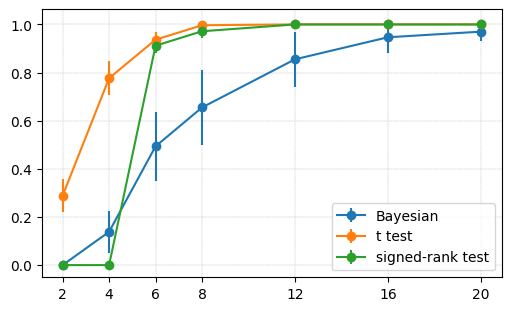

In [10]:
nrows, ncols = 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True)
ax = axes[0, 0]

arr = ((mu_a_delta < 0).mean(axis=(-1, -2, 3)) > .95).mean(axis=-1)
me = arr.mean(axis=-1)
sem = stats.sem(arr, axis=-1)
std = arr.std(axis=-1)
ax.errorbar(x=N_space, y=me, yerr=std, marker="o", label="Bayesian")

arr = (p_value < .05).mean(axis=-2)
me = arr.mean(axis=-2)
sem = stats.sem(arr, axis=-2)
std = arr.std(axis=-2)
ax.errorbar(x=N_space, y=me[:, 0], yerr=std[:, 0], marker="o", label="t test")
ax.errorbar(x=N_space, y=me[:, 1], yerr=std[:, 1], marker="o", label="signed-rank test")

ax.grid(linewidth=.3, linestyle="--", axis="both")
ax.set_yticks(np.arange(0, 1.2, .2))
ax.set_xticks(N_space)
ax.legend();


In [11]:
prefix_2 = "mu_a_delta_-1.5_sigma_a_delta_1"

mu_a_delta = None

for N in N_space:
    curr_N_mu_delta = None
    N_dir = f"N_{N}"

    for draw_ind in draws_space[:12]:
        curr_draw_mu_delta = None
        draw_dir = f"draw_{draw_ind}"

        for seed in repeats_space:
            seed_dir = f"seed_{seed}"

            src = os.path.join(MODEL.build_dir, prefix, prefix_2, draw_dir, N_dir, seed_dir, "mu_a_delta.npy")
            mu_delta_temp = np.load(src)

            mu_delta_temp = mu_delta_temp[None, ...]

            if curr_draw_mu_delta is None:
                curr_draw_mu_delta = mu_delta_temp
            else:
                curr_draw_mu_delta = np.concatenate([curr_draw_mu_delta, mu_delta_temp], axis=0)

        curr_draw_mu_delta = curr_draw_mu_delta[None, ...]

        if curr_N_mu_delta is None:
            curr_N_mu_delta = curr_draw_mu_delta
        else:
            curr_N_mu_delta = np.concatenate([curr_N_mu_delta, curr_draw_mu_delta], axis=0)

    curr_N_mu_delta = curr_N_mu_delta[None, ...]

    if mu_a_delta is None:
        mu_a_delta = curr_N_mu_delta
    else:
        mu_a_delta = np.concatenate([mu_a_delta, curr_N_mu_delta], axis=0)

mu_a_delta_15 = mu_a_delta.copy()

In [12]:
prefix_2 = "mu_a_delta_-3_sigma_a_delta_1"

mu_a_delta = None

for N in N_space:
    curr_N_mu_delta = None
    N_dir = f"N_{N}"

    for draw_ind in draws_space[:9]:
        curr_draw_mu_delta = None
        draw_dir = f"draw_{draw_ind}"

        for seed in repeats_space:
            seed_dir = f"seed_{seed}"

            src = os.path.join(MODEL.build_dir, prefix, prefix_2, draw_dir, N_dir, seed_dir, "mu_a_delta.npy")
            mu_delta_temp = np.load(src)

            mu_delta_temp = mu_delta_temp[None, ...]

            if curr_draw_mu_delta is None:
                curr_draw_mu_delta = mu_delta_temp
            else:
                curr_draw_mu_delta = np.concatenate([curr_draw_mu_delta, mu_delta_temp], axis=0)

        curr_draw_mu_delta = curr_draw_mu_delta[None, ...]

        if curr_N_mu_delta is None:
            curr_N_mu_delta = curr_draw_mu_delta
        else:
            curr_N_mu_delta = np.concatenate([curr_N_mu_delta, curr_draw_mu_delta], axis=0)

    curr_N_mu_delta = curr_N_mu_delta[None, ...]

    if mu_a_delta is None:
        mu_a_delta = curr_N_mu_delta
    else:
        mu_a_delta = np.concatenate([mu_a_delta, curr_N_mu_delta], axis=0)

mu_a_delta_30 = mu_a_delta.copy()

In [13]:
prefix_2 = "mu_a_delta_0_sigma_a_delta_1"

mu_a_delta = None

for N in N_space:
    curr_N_mu_delta = None
    N_dir = f"N_{N}"

    for draw_ind in draws_space[:3]:
        curr_draw_mu_delta = None
        draw_dir = f"draw_{draw_ind}"

        for seed in repeats_space:
            seed_dir = f"seed_{seed}"

            src = os.path.join(MODEL.build_dir, prefix, prefix_2, draw_dir, N_dir, seed_dir, "mu_a_delta.npy")
            mu_delta_temp = np.load(src)

            mu_delta_temp = mu_delta_temp[None, ...]

            if curr_draw_mu_delta is None:
                curr_draw_mu_delta = mu_delta_temp
            else:
                curr_draw_mu_delta = np.concatenate([curr_draw_mu_delta, mu_delta_temp], axis=0)

        curr_draw_mu_delta = curr_draw_mu_delta[None, ...]

        if curr_N_mu_delta is None:
            curr_N_mu_delta = curr_draw_mu_delta
        else:
            curr_N_mu_delta = np.concatenate([curr_N_mu_delta, curr_draw_mu_delta], axis=0)

    curr_N_mu_delta = curr_N_mu_delta[None, ...]

    if mu_a_delta is None:
        mu_a_delta = curr_N_mu_delta
    else:
        mu_a_delta = np.concatenate([mu_a_delta, curr_N_mu_delta], axis=0)

mu_a_delta_00 = mu_a_delta.copy()

In [14]:
prefix_2 = "mu_a_delta_-4.5_sigma_a_delta_1"

mu_a_delta = None

for N in N_space:
    curr_N_mu_delta = None
    N_dir = f"N_{N}"

    for draw_ind in draws_space[:16]:
        curr_draw_mu_delta = None
        draw_dir = f"draw_{draw_ind}"

        for seed in repeats_space:
            seed_dir = f"seed_{seed}"

            src = os.path.join(MODEL.build_dir, prefix, prefix_2, draw_dir, N_dir, seed_dir, "mu_a_delta.npy")
            mu_delta_temp = np.load(src)

            mu_delta_temp = mu_delta_temp[None, ...]

            if curr_draw_mu_delta is None:
                curr_draw_mu_delta = mu_delta_temp
            else:
                curr_draw_mu_delta = np.concatenate([curr_draw_mu_delta, mu_delta_temp], axis=0)

        curr_draw_mu_delta = curr_draw_mu_delta[None, ...]

        if curr_N_mu_delta is None:
            curr_N_mu_delta = curr_draw_mu_delta
        else:
            curr_N_mu_delta = np.concatenate([curr_N_mu_delta, curr_draw_mu_delta], axis=0)

    curr_N_mu_delta = curr_N_mu_delta[None, ...]

    if mu_a_delta is None:
        mu_a_delta = curr_N_mu_delta
    else:
        mu_a_delta = np.concatenate([mu_a_delta, curr_N_mu_delta], axis=0)

mu_a_delta_45 = mu_a_delta.copy()

In [15]:
mu_a_delta_15.shape

(7, 12, 50, 4000, 1, 1)

In [16]:
mu_a_delta_30.shape

(7, 9, 50, 4000, 1, 1)

In [17]:
mu_a_delta_00.shape

(7, 3, 50, 4000, 1, 1)

In [18]:
mu_a_delta_45.shape

(7, 16, 50, 4000, 1, 1)

In [19]:
def _process(arr, rope):
    arr = ((arr < rope).mean(axis=(-1, -2, 3)) > .95).mean(axis=-1)
    me = arr.mean(axis=-1)
    sem = stats.sem(arr, axis=-1)
    std = arr.std(axis=-1)
    return me, sem, std


In [27]:
d = {
    "N(-1.5, 1)": mu_a_delta_15,
    "N(-3, 1)": mu_a_delta_30,
    # "N(0, 1)": mu_a_delta_00,
    "N(-4.5, 1)": mu_a_delta_45
}


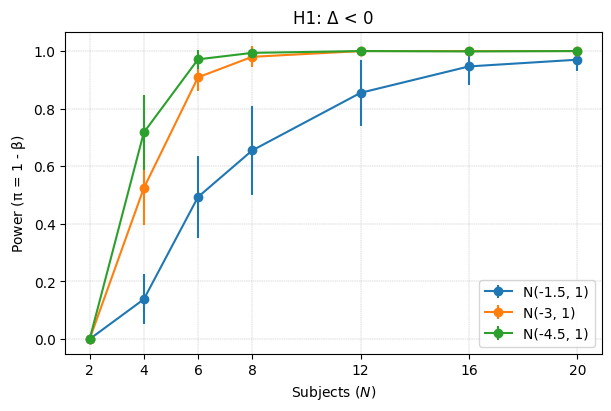

In [41]:
rope_space = [0]

nrows, ncols = 1, len(rope_space)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows), squeeze=False, constrained_layout=True, sharex=True, sharey=True)

i = 0
for rope in rope_space:
    ax = axes[i // ncols, i % ncols]

    for u, v in d.items():
        me, sem, std = _process(v, rope)
        ax.errorbar(x=N_space, y=me, yerr=std, marker="o", label=f"{u}")

    ax.grid(linewidth=.3, linestyle="--", axis="both")
    ax.set_yticks(np.arange(0, 1.2, .2))
    ax.set_xticks(N_space)

    ax.set_title(f"H1: Δ < {rope}")
    ax.set_xlabel("Subjects $(N)$")
    ax.set_ylabel("Power $($π = 1 - β$)$")

    ax.yaxis.set_tick_params(labelleft=True)
    ax.legend(loc="lower right")
    # ax.axhline(0.05)

    i += 1

# fig.suptitle(f"Power Analysis with {12} draws, {n_repeats} repeats\nError bars are standard deviations");